<img src="https://www.digitalhouse.com/logo-DH.png" width="200" height="100" align="left">

<h3><b>Curso:</b> Data Science / <b>Año:</b> 2020 / <b>Sede:</b> Casa</h3>

-----

<h3><b>TP Integrador:</b> Text Mining de <i>tweets</i> de anuncios del gobierno durante la cuarentena.</h3>
<blockquote>
        <ul>
          <li><i>Sentiment analysis</i> de los comentarios de los usuarios.</li>
          <li>Clustering de <i>tweets</i> de los usuarios.</li>
        </ul>
</blockquote>

<h3><b>Grupo 10:</b></h3>
<blockquote>
        <ul>
          <li>Maria Eugenia Perotti</li>
          <li>Gastón Ortíz</li>
        </ul>
</blockquote>

### Tabla de contenidos
* [Prepocesamiento](#preprocesamiento)
* [Ley de Zipf](#zip)
* [Nube de palabras](#nube)
* [Implementación de modelos](#modelos)
* [Evaluación de modelos](#evaluacion)
* [Analisis de modelo](#analisis)
* [Puesta en producción](#puesta)

# Topic Model
Una rama de machine learning y del procesamiento del lenguage natural es topic model, que consiste en descubrir los temas abstractos que se encuentran en una coleccion de documentes, en nuestro caso en los tweets recolectados en la notebook 1. Utilizando topic modeling podemos encontrar estructuras semanticas ocultas en los textos. Los temas producidos por los algoritmos generan cluster de palabras similares.

En esta notebook se utilizara tecnicas de topic modeling para encontrar los temas ocultos en los tweet a lo largo de toda la cuarentena. Los algoritmos utilizados son los siguientes: 
* Latent Dirichlet Allocation

## Importación de librerias
Importamos las librerias que utilizaremos

In [29]:
#  Librerias basicas 
import numpy as np
import pandas as pd
import os
import unidecode
import string
import datetime

# Librerias de visualización
import matplotlib.pyplot as plt
import matplotlib.patches as mpatche
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
%matplotlib inline

# Librerias para nlp y obtención de los datos
import GetOldTweets3 as got
from nltk.corpus import stopwords
import spacy
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from spacy import displacy

# Librerias para los modelos
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, TfidfModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

# Para ignorar los warnings
import warnings
warnings.filterwarnings('ignore')

Los tweets que se utlizan son los mismo obtenidos en la notebook 1

In [30]:
df = pd.read_csv("./Data/all_tweets_ultimo.csv")
df.drop_duplicates(subset="tweet",inplace=True)

In [31]:
# Se visualizan unos 5 tweets al azar para ver como estan compuestos
pd.set_option("max_colwidth",None)
df.sample(5)

,username,tweet,fecha,anuncio,ubicacion,id
4117,LeandroDaCruz14,el federalismo del coronavirus llega mas tarde a las provincias la argentina misma,2020-08-14 17:25:41+00:00,Anuncio_11,"Buenos Aires, Argentina",1294324328503402498
5487,LosAndesDiario,el ex legislador gustavo gutierrez tiene coronavirus y esta internado,2020-08-14 15:25:00+00:00,Anuncio_11,"Mendoza, Argentina",1294293954477862912
2246,sebamurstein,los videos de tik tok estan haciendo mas dano que el coronavirus,2020-04-10 17:03:19+00:00,Anuncio_3,"Buenos Aires, Argentina",1248657825175396353
803,HanzoBlackMamba,atencion ciudadanos de buenos aires vayan tomando conciencia por favor y a prepararse para lo que se viene yomequedoenmicasa coronavirus coronavirusenargentina quedateencasa cuarentenanacional,2020-03-19 02:12:45+00:00,Anuncio_1,"Buenos Aires, Argentina",1240461173369311232
2948,roman_campagna,che no se si soy el unico que le pasa pero pienso que ya paso el coronavirus x mi cuerpo y se fue,2020-05-08 00:59:01+00:00,Anuncio_5,"Mendoza, Argentina",1258562012768018436


<a id="preprocesamiento"></a>

## Preprocesamiento

### Clase para Tokenizar y limpiar los datos con spaCy

Usaremos esta clase para eliminar automáticamente la información que no necesitamos, como palabras vacías, stopwords y signos de puntuación, de cada tweet.

Primero importamos los modelos de Español y el módulo de string de Python, que contiene una lista de todos los signos de puntuación que podemos usar en `string.punctuation`. Crearemos variables que contienen los signos de puntuación y las palabras vacías que queremos eliminar, y un analizador que ejecuta la entrada a través del módulo de español de spaCy.

Para continuar limpiando nuestros datos, primero la clase elimina los espacios iniciales y finales y convierte el texto en minúsculas.Luego, a cada tweet lo procesa y cada palabra se convierte en _tokens_, realizando lematización y pasando todo a minúsculas. 

In [32]:
# Cargamos el modelo en españo del spacy
nlp = spacy.load("es_core_news_sm")

# Creamos nuestra lista de signos de puntuación.
punctuations = string.punctuation

# Creamos nuestra lista de stopwords
nlp = spacy.load("es_core_news_sm")

# Creo las stopwords que no van a ser tenidas en cuenta para el Count Vectorizer.
# Utilizo las stopwords predefinidas de nltk y spacy
# Además se agregan como stopwords las palabras con las que buscamos los tweets
stop_words_propias = ["coronavirus","covid","covid19","corona","Alberto","cuarentena","alferdez"]
stopwords_sp = stopwords.words('spanish')
stopwords_sp += stop_words_propias
spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS
stop_words = spacy_stopwords.union(stopwords_sp)

# Cargamos el tokenizador, tagger, parser, NER y los word vectors del Español.
parser = Spanish()

In [33]:
class Preprocesamiento():
#     def __init__(self):
#         self.texto = texto
    def clean_text(self,text):
        # Removing spaces and converting text into lowercase
        return text.strip().lower()
    def transform(self,text):
        # Cleaning Text
        return [self.clean_text(texto) for texto in text]
    def spacy_tokenizer(self,sentence):
        # Creamos nuestro objeto token, que va a ser utilizado para crear documentos con anotaciones lingüísticas.
        mytokens = parser(sentence)
        # Eliminamos los numeros
        mytokens = [word for word in mytokens if not word.like_num]

        # Lematizamos cada token y lo pasamos a minúsculas.
        mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

        # Sacamos las stop words
        mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]

        mytokens = [word for word in mytokens if len(word) > 2] 

        # retorna la lista de tokens preprocesada
        return mytokens
    def texto_listo(self,texto):
        lista = []
        for tweet in self.transform(texto):
            lista.append(self.spacy_tokenizer(tweet))
        return lista

<a id="zipf"></a>
## La ley de Zipf
La ley de zips indica que la frecuencia de aparición de distintas palabras sigue una distribución que puede aproximarse por:
 $$P_n \approx 1/n^a$$
donde \begin{equation}P_n\end{equation} representa la frecuencia de la n-ésima palabra más frecuente y el exponente a es un número real positivo, en general ligeramente superior a 1​ Esto significa que el segundo elemento se repetirá aproximadamente con una frecuencia de 1/2 de la del primero, el tercer elemento con una frecuencia de 1/3 del primero y así sucesivamente. Esta ley es interesante ya que además de aplicarse a diferentes lenguas se aplica en otros ambito. Como por ejemplo en las cuidades de un pais donde generalmente la ciudad mas grande de un país tiene el doble de población que la segunda ciudad mas grande.

Generamos una matriz esparza de Bag of words para nuestros datos de texto utilizando `CountVectorizer` de scikit-learn para contar la ocurrencia de cada palabra en los diferentes tweets. Despues con la matriz generamos un data frame, utilizando como columnas las palabras

In [34]:
palabras = ["coronavirus","covid","covid19","corona","Alberto","cuarentena","alferdez"]
vector = CountVectorizer(stop_words=palabras)
matriz_sparza = vector.fit_transform(df.tweet)
palabras_tweet = pd.DataFrame(matriz_sparza.toarray(),columns= vector.get_feature_names())

In [35]:
# Sumamos la cantidad de veces que aparece cada palabra en todo el corpus, es decir en toda la colección de tweets
frecuencia_palabras = palabras_tweet.sum(axis=0).sort_values(ascending=False)
frecuencia_palabras.head(10)

de     6567
el     4435
la     3905
en     3749
que    3455
no     1644
los    1584
por    1477
del    1344
se     1339
dtype: int64

Segun la RAE las diez palabras más frecuentes son de, la, que, el, en, y, a, los, se, del. Las 10 palabras mas usadas en los tweet son las misma salvo por no, por y se.

In [36]:
total_palabras = frecuencia_palabras.sum()
cant_palabras_unicas = frecuencia_palabras.shape[0]
# Vemos el total de palabras
total_palabras

112900

Graficamos la frecuencia de aparición de las primeras 400 palabras que aparecen en todos los tweets

Text(0.5, 1.0, 'Top 400 palabras en tweets')

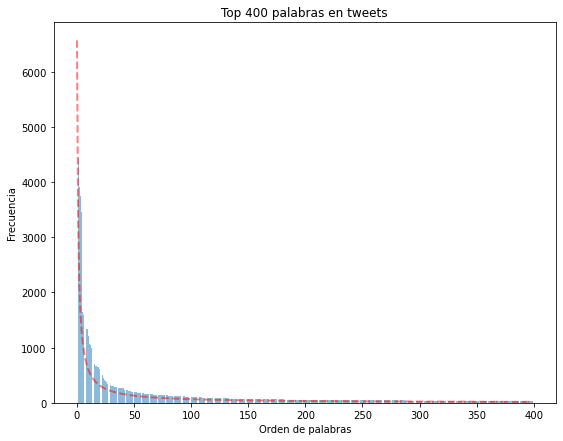

In [37]:
y_pos = np.arange(400)
plt.figure(figsize=(9,7))
s = 1
frecuencia_esperada = [frecuencia_palabras[0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, frecuencia_palabras[:400], align='center', alpha=0.5)
plt.plot(y_pos, frecuencia_esperada, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frecuencia')
plt.xlabel('Orden de palabras')
plt.title('Top 400 palabras en tweets')

La distribución de Zipf es una analoga a la distribución de probabilidad continua de Pareto. Por tal similaridad la distribución Zipf es llamada distribución discreta de Pareto. 

La distribución de Pareto es muy conocida por su famoso resultado, en donde el 20% de los factores explican el 80% de los resultados. Pata ver si esto se cumple con las palabras de los tweets esperamos que el 20% de las palabras expliquen aproximadamente el 80% del contenido de los tweets.

In [38]:
# Si las palabras seguirian la ley de pareto esperamos que el 20% de la palabras comprendan aproximadamente el 80% de la cantidad total de palabras en los tweets
frecuencia_palabras[:int(cant_palabras_unicas * 0.2)].sum() / total_palabras

0.8476970770593446

El 20% de las palabras comprende el 84% del contenido total de los tweets.

Graficamos la frecuencia absoluta de las palabras contra el ranking de frecuencia de las palabras. El grafico esta en escala logaritmica 

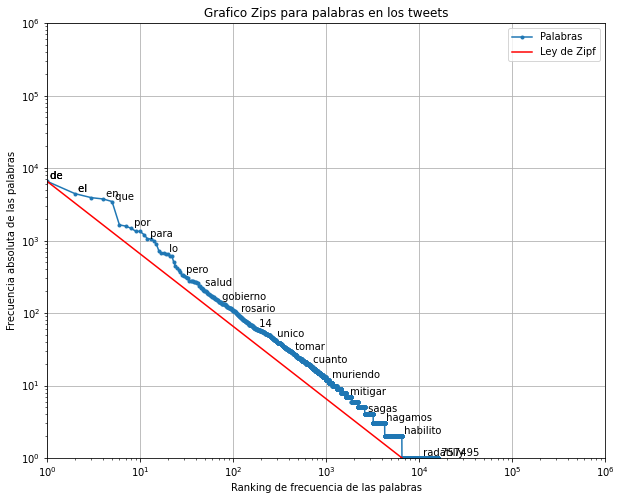

In [39]:
from pylab import *
counts = frecuencia_palabras.values
tokens = frecuencia_palabras.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(10,8))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Grafico Zips para palabras en los tweets")
xlabel("Ranking de frecuencia de las palabras")
ylabel("Frecuencia absoluta de las palabras")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")
plt.legend(["Palabras","Ley de Zipf"])

En el siguente grafico si ve que las frecuencia de ocurrencia de las palabras sigue aproximadamente la ley de Zipf. La linea roja seria el caso en el que las palabras sigan exactamente una distribución Zipf. Se aprecia que la frecuencia de las palabras es un poco mas elevada de lo que la ley Zipf prevee

Si les interesa aprender mas sobre la ley de zipf les recomiendo leer el siguente enlance y ver el video que se encuentra ahí. https://www.microsiervos.com/archivo/ciencia/misterio-ley-zipf-y-lenguaje.html

<a id="nube"></a>
## Wordcloud
Una vez limpio el data set podemos proceder a visualizar un poco los datos para ganar mas intuición sobre los mismos. Para tal fin se va utilizar la libreria wordcloud que permite generar visualizaciones llamativas, mejor conocidas como nube de palabras. Estas imagenes muestran las palabras mas utilizadas en el data set luego de eliminar las stopwords ya que sino estas coparian toda la imagen.

Primero se hace una nube de palabras con las mas utilizadas en todo el dataset para ver cuales son las mas utilizadas.

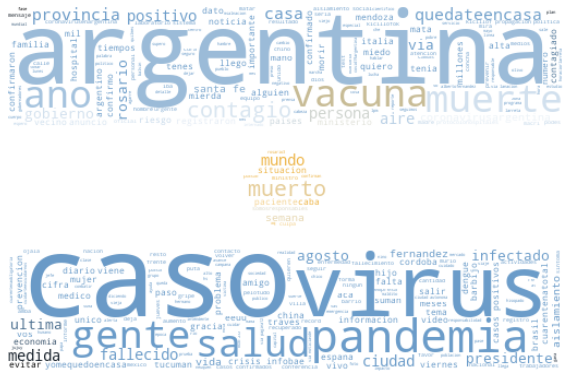

In [40]:
mask = np.array(Image.open("./imagenes/arg02.png").convert("RGB"))
# mask = np.array(Image.open("./roja.png"))
wordcloud_usa = WordCloud(stopwords=stop_words, background_color="white", mode="RGBA", max_words=500, mask=mask, random_state=42).generate(df.tweet.str.cat(sep=" "))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
# plt.title("Toda la cuarentena")
plt.savefig("imagenes/nube_total.png", format="png")
plt.show()

Las palabras mas utilizadas a lo largo de toda la cuarentena son Argentina, caso, virus, pandemia, muerte, salud, gente, etc.

Para ver si estas palabras cambian con el tiempo a lo largo de los anuncios de la cuarentena, se tomó el anuncio 1, el 6 y el ultimo anuncio, el numero 11.

Nube de palabras en el Anuncio_1


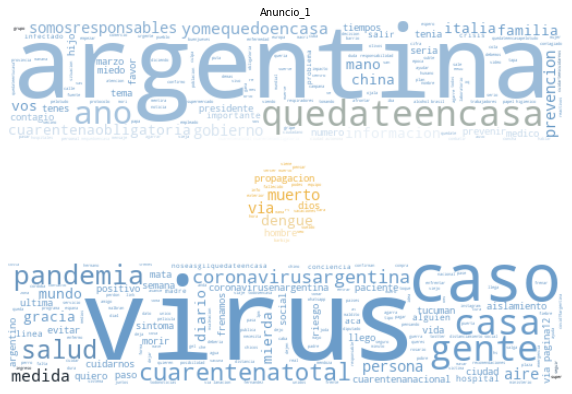

Nube de palabras en el Anuncio_6


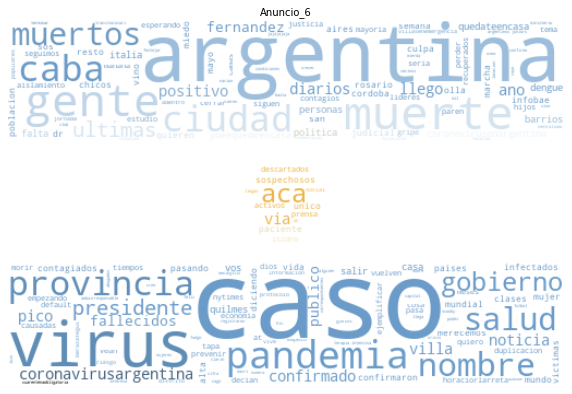

Nube de palabras en el Anuncio_11


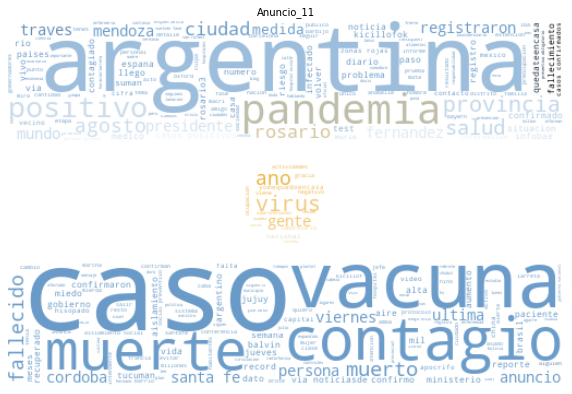

In [41]:
for anuncio in df[(df.anuncio == "Anuncio_1") | (df.anuncio == "Anuncio_6") | (df.anuncio == "Anuncio_11")].anuncio.unique():
    wordcloud_usa = WordCloud(stopwords=stop_words, background_color="white", mode="RGBA", max_words=1000, mask=mask, random_state=42).generate(df[df.anuncio == anuncio].tweet.str.cat(sep=" "))

    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")

    # store to file
    plt.title(anuncio,fontsize=10)
    plt.savefig("imagenes/nube_{}.png".format(anuncio), format="png")
    print("Nube de palabras en el {}".format(anuncio))
    plt.show()

Haciendo una comparación del primer anuncio y los anuncios 6 y 11, se ve que en el primer anuncio la frase quedate en casa es una de las mas utilizadas, despues se ve que su utilización fue disminuyendo. Si comparamos la primer nube de palabras con la ultima, se ve que en la ultima ganan fuerza las palabras como vacuna, muerte y contagio 

<a id="modelos"></a>
## Implementación de modelo utilizando la libreria Gensim
Los algoritmso utilisados son los siguientes:
* Latent Dirichlet Allocation(LDA): es un modelo generativo que permite que conjuntos de observaciones puedan ser explicados por grupos no observados que explican porqué algunas partes de los datos son similares. Por ejemplo, si las observaciones son palabras en documentos, presupone que cada documento es una mezcla de un pequeño número de categorías (también denominados como tópicos) y la aparición de cada palabra en un documento se debe a una de las categorías a las que el documento pertenece.
* Latent Semantic Indeixing(LSI): Analiza las relaciones entre documentos, primero realiza un matriz que contiene el conteo de las palabras en los distintos documentos, como en count vectorizer. Luego realiza una tecnica de reduccion de la dimensionalidad llamada singular value decomposition y agrupa entre los temas predefinidos a entrenar el modelo  
* Hierarchical Dirichlet Process(HDP): Al contrario del LDA, este algoritmo infiere los temas de los datos automaticamente. 



Se procede primero a limpiar los datos primero utilizamos las funciones que creamos

In [42]:
preprocesador = Preprocesamiento()
tweets_listos = preprocesador.texto_listo(df.tweet)

Se crean bigramas para tratar de mejor los temas que encuentran los algoritmos

In [43]:
bigram = gensim.models.Phrases(tweets_listos)

Se crea una lista con los bigramas incluidos

In [44]:
texts = [bigram[line] for line in tweets_listos]

Se crean los diccionarios de palabras y el corpus para poder entrenar los modelos

In [45]:
dictionary = Dictionary(tweets_listos)
corpus = [dictionary.doc2bow(text) for text in tweets_listos]

Generamos tambien un corpus con el modelo tf_idf para poder normalizar los datos teniendo en cuenta su frecuencia. Con esto ganamos que si una palabra que aparece muchas veces en un documento, pero pocas veces en los demás, es una palabra muy distintiva de ese documento y será importante para representarlo, mientras que palabras que aparecen pocas veces, o que aparecen en muchos documentos serán menos informativas. Probaremos con los 2 corpus y veremos cual es mas entendible. Cuanto mayor sea el TF-IDF, más importante es ese término para ese tweet.

In [46]:
tfidf = TfidfModel(corpus = corpus,id2word=dictionary)
corpus_tfidf = tfidf[corpus]

### Latent Dirichlet Allocation
Empezamos con el argortimo mas famoso en topic model Latent Dirichlet Allocation utilizando el corpus vectorizado y le definimos como parámetro el numero de temas que queremos

In [47]:
lda_model = LdaModel(corpus=corpus, num_topics=3, id2word=dictionary,random_state=42)

Visualizamos los 3 topicos encontramos por el modelo. 

In [48]:
lda_model.show_topics()

[(0,
  '0.027*"caso" + 0.014*"argentino" + 0.010*"positivo" + 0.009*"parir" + 0.009*"confirmar" + 0.008*"provincia" + 0.008*"santo" + 0.007*"vacuno" + 0.007*"muerte" + 0.007*"contagio"'),
 (1,
  '0.018*"parir" + 0.010*"argentino" + 0.009*"comer" + 0.008*"virus" + 0.006*"coronar" + 0.006*"salud" + 0.005*"pandemia" + 0.005*"gobernar" + 0.005*"contagiar" + 0.005*"caso"'),
 (2,
  '0.020*"parir" + 0.010*"argentino" + 0.008*"caso" + 0.008*"morir" + 0.007*"comer" + 0.006*"muerte" + 0.006*"virus" + 0.006*"hablar" + 0.006*"ano" + 0.005*"pandemia"')]

Creo una función para mostrar las primeras 10 palabras clave de cada tema

In [49]:
def palabras_claves(modelo):
    temas = len(modelo.show_topics())
    columns = ["Tema"+str(i) for i in range(temas)]
    palabras = pd.DataFrame(data=np.zeros((10,temas)),columns=columns)
    for i in range(temas):
        wp = modelo.show_topic(i)                
        # sepero cada palabra que compone al tema principal por una coma
        topic_keywords = ", ".join([word for word, prop in wp])
        for index, (word,prop) in enumerate(wp):
            palabras["Tema"+str(i)][index] = word
    return palabras

In [50]:
palabras_claves(lda_model)

,Tema0,Tema1,Tema2
0,caso,parir,parir
1,argentino,argentino,argentino
2,positivo,comer,caso
3,parir,virus,morir
4,confirmar,coronar,comer
5,provincia,salud,muerte
6,santo,pandemia,virus
7,vacuno,gobernar,hablar
8,muerte,contagiar,ano
9,contagio,caso,pandemia


Ahora utilizando el mismo algoritmo pero cambiando el corpus por el que tiene las palabras normalizadas gracias a la transformación tf_idf

In [51]:
lda_model_tfidf = LdaModel(corpus=corpus_tfidf, num_topics=3, id2word=dictionary,random_state=42)

Visualizamos los 3 topicos encontramos por el modelo. 

In [52]:
lda_model_tfidf.show_topics()

[(0,
  '0.009*"caso" + 0.005*"positivo" + 0.005*"provincia" + 0.005*"santo" + 0.004*"confirmar" + 0.004*"argentino" + 0.003*"muerte" + 0.003*"rosario" + 0.003*"parir" + 0.003*"vacuno"'),
 (1,
  '0.003*"parir" + 0.003*"caso" + 0.003*"balvin" + 0.003*"virus" + 0.003*"argentino" + 0.003*"coronar" + 0.002*"comer" + 0.002*"vacuno" + 0.002*"salud" + 0.002*"contagiar"'),
 (2,
  '0.007*"argentino" + 0.006*"muerte" + 0.005*"caso" + 0.005*"fallecido" + 0.004*"agostar" + 0.004*"contagio" + 0.004*"ultimar" + 0.004*"registrar" + 0.004*"muerto" + 0.004*"parir"')]

Vemos las palabras claves de cada tema

In [53]:
palabras_claves(lda_model_tfidf)

,Tema0,Tema1,Tema2
0,caso,parir,argentino
1,positivo,caso,muerte
2,provincia,balvin,caso
3,santo,virus,fallecido
4,confirmar,argentino,agostar
5,argentino,coronar,contagio
6,muerte,comer,ultimar
7,rosario,vacuno,registrar
8,parir,salud,muerto
9,vacuno,contagiar,parir


Gracias a la libreria pyLDAvis podemos visualizar los topicos y ver la frecuencia de palabras que lo componen. Esta libreria nos brinda una visualización amigable que nos facilita poder interpretar mejor los temas que generan los modelos. Primero el modelo con el corpus vectorizado y despues con el corpus con la transformacion tf_idf

In [54]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.036128  0.045058       1        1  39.540874
2     -0.022423 -0.052684       2        1  34.728661
1      0.058551  0.007626       3        1  25.730457, topic_info=           Term        Freq       Total Category  logprob  loglift
1830    agostar   76.000000   76.000000  Default  30.0000  30.0000
317      balvin   45.000000   45.000000  Default  29.0000  29.0000
3902     record   59.000000   59.000000  Default  28.0000  28.0000
2479  provincia  126.000000  126.000000  Default  27.0000  27.0000
215       santo  128.000000  128.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2479  provincia   20.044472  126.438675   Topic3  -6.5374  -0.4843
531         via   17.291248   86.648346   Topic3  -6.6852  -0.2542
4191    mendoza   17.073109   74.743431   Topic3  -6.6979  -0.1191
3         gente   16.949211   68.697052   Topic3  -6.7051  -0.0420
15       seguir   16.954508   77.407715   Topic3  -6.7048  -0.1611

[233 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
414       1  0.093186           actual
414       2  0.093186           actual
414       3  0.838675           actual
3912      1  0.120411       actualidad
3912      2  0.060206       actualidad
...     ...       ...              ...
182       2  0.267286  yomequedoencasa
182       3  0.504873  yomequedoencasa
437       1  0.804702             zona
437       2  0.129791             zona
437       3  0.051916             zona

[525 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [55]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.036128  0.045058       1        1  37.300224
2     -0.022423 -0.052684       2        1  34.289463
1      0.058551  0.007626       3        1  28.410313, topic_info=           Term       Freq      Total Category  logprob  loglift
1830    agostar  22.000000  22.000000  Default  30.0000  30.0000
317      balvin  14.000000  14.000000  Default  29.0000  29.0000
3902     record  16.000000  16.000000  Default  28.0000  28.0000
2479  provincia  36.000000  36.000000  Default  27.0000  27.0000
215       santo  36.000000  36.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
2479  provincia   6.578866  36.480240   Topic3  -6.5374  -0.4545
531         via   5.675221  25.473431   Topic3  -6.6852  -0.2431
4191    mendoza   5.603624  21.794838   Topic3  -6.6979  -0.0998
3         gente   5.562959  20.293711   Topic3  -6.7051  -0.0358
15       seguir   5.564698  22.766745   Topic3  -6.7048  -0.1504

[234 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
414       3  0.875242           actual
3912      1  0.188273       actualidad
3912      3  0.753094       actualidad
1037      3  0.828995         acumular
1830      1  0.044500          agostar
...     ...       ...              ...
182       2  0.289712  yomequedoencasa
182       3  0.482853  yomequedoencasa
437       1  0.821482             zona
437       2  0.182552             zona
437       3  0.091276             zona

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### Latent Semantic Indeixing
Siguiendo con el algoritmo Latent Semantic Indeixing. Podemos comparar los temas encontrados y ver cual es que mas sentido encontramos. Al igual que con Latent Dirichlet Allocation se utilizan los dos corpus diferentes

In [56]:
lsi_model = LsiModel(corpus=corpus, num_topics=3, id2word=dictionary)

In [57]:
lsi_model.show_topics()

[(0,
  '0.786*"parir" + 0.269*"caso" + 0.263*"argentino" + 0.139*"comer" + 0.128*"virus" + 0.111*"pandemia" + 0.086*"confirmar" + 0.083*"salud" + 0.082*"coronar" + 0.076*"casar"'),
 (1,
  '-0.714*"caso" + 0.460*"parir" + -0.282*"argentino" + -0.216*"confirmar" + -0.155*"muerte" + -0.116*"positivo" + -0.096*"registrar" + -0.091*"fallecido" + -0.082*"contagio" + -0.082*"ultimar"'),
 (2,
  '-0.765*"argentino" + 0.422*"caso" + 0.240*"parir" + -0.190*"virus" + -0.139*"coronar" + -0.129*"comer" + -0.093*"muerto" + 0.088*"confirmar" + -0.083*"morir" + -0.079*"pandemia"')]

Vemos las palabras claves de cada tema

In [58]:
palabras_claves(lsi_model)

,Tema0,Tema1,Tema2
0,parir,caso,argentino
1,caso,parir,caso
2,argentino,argentino,parir
3,comer,confirmar,virus
4,virus,muerte,coronar
5,pandemia,positivo,comer
6,confirmar,registrar,muerto
7,salud,fallecido,confirmar
8,coronar,contagio,morir
9,casar,ultimar,pandemia


In [59]:
lsi_model_tfidf = LsiModel(corpus=corpus_tfidf, num_topics=3, id2word=dictionary)

In [60]:
lsi_model_tfidf.show_topics()

[(0,
  '0.523*"caso" + 0.359*"muerte" + 0.338*"argentino" + 0.274*"confirmar" + 0.203*"registrar" + 0.179*"ultimar" + 0.177*"fallecido" + 0.171*"hora" + 0.146*"muerto" + 0.133*"contagio"'),
 (1,
  '0.524*"coronar" + 0.513*"virus" + 0.210*"parir" + -0.181*"caso" + -0.149*"muerte" + 0.137*"morir" + 0.137*"comer" + -0.117*"registrar" + 0.114*"vacuno" + 0.110*"casar"'),
 (2,
  '-0.500*"caso" + 0.472*"muerte" + 0.309*"argentino" + 0.264*"hora" + 0.240*"ultimar" + -0.208*"santo" + -0.200*"provincia" + -0.154*"rosario" + -0.130*"ciudad" + 0.120*"contagio"')]

Vemos las palabras claves de cada tema

In [61]:
palabras_claves(lsi_model_tfidf)

,Tema0,Tema1,Tema2
0,caso,coronar,caso
1,muerte,virus,muerte
2,argentino,parir,argentino
3,confirmar,caso,hora
4,registrar,muerte,ultimar
5,ultimar,morir,santo
6,fallecido,comer,provincia
7,hora,registrar,rosario
8,muerto,vacuno,ciudad
9,contagio,casar,contagio


### Hierarchical Dirichlet Process
Se utiliza el ultimos modelos Hierarchical Dirichlet Process. Al contrario que los otros dos algoritmos, HDP elige el numero optimo de topics

In [62]:
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)

In [63]:
len(hdp_model.show_topics())

20

Vemos las palabras claves de cada tema

In [64]:
palabras_claves(hdp_model)

,Tema0,Tema1,Tema2,Tema3,Tema4,Tema5,Tema6,Tema7,Tema8,Tema9,Tema10,Tema11,Tema12,Tema13,Tema14,Tema15,Tema16,Tema17,Tema18,Tema19
0,parir,parir,parir,parir,argentino,caso,caso,caso,parir,parir,tumbar,caso,hijita,caso,parir,parir,caso,parir,parir,caso
1,caso,argentino,malo,caso,muerte,parir,confirmar,parir,caso,gente,rugbier,argentino,parir,confirmar,manejate,qacoficial,argentino,desabastecimiento,kamala,argentino
2,argentino,caso,taxista,cercania,parir,dancer,positivo,generacionesdeja,ciudad,casar,jeikei,archi,problema,coronar,cuota,conicetdialoga,ingresar,mediocre,edelweiss,confirmar
3,anunciar,muerto,argentino,callar,caso,caostotal,parir,cuestion,tufillo,eficacia,teleconferencia,cronograma,alimentosque,comer,embargar,queeeeeeee,reconstruccion,gente,graficas,salir
4,seguir,comer,amigar,larc,empezo,rosario,mujer,no158,libertad,via,exigira,creador,enmascarar,parir,teavise,argentino,kicillofrepresor,ficaemcasa,pecar,contagiar
5,alberto,ultimar,licdanielarroyo,argentino,alberto,argentino,provincia,arroyar,vigilancia,ano,afiliar,contento,caso,positivo,virus,concentración,deporte,casar,judicial,muerte
6,presidente,fallecido,online,serienetflix,ingresar,jaimepumarejo,argentino,zapping,terminar,virus,parir,pandenmia,pablar,argentino,caso,ctan,regio,jueguitos,quedateencasa,correr
7,recepcion,cama,monitoreando,familiayvidarqt,gente,frecuente,ultimar,raza,argentino,jones,argentino,acordas,lastimar,anunciar,muerte,ambiente,maltratoinfantil,extinguir,brusela,puma
8,medir,hora,lemon,filosofar,dorm,tomar,naranja,alfonsino,calificar,estadisticas,controlarme,buenfinde,personar,via,cuandollegalavacuna,osvaldo,tocarte,gobernar,centralismo,parir
9,virus,muerte,aislamiento,abortivo,diluir,presidente,lilita,guitarrista,gente,paranoico,marciano,bronquitis,hipocraticohomenaje,msaludtuc,infobaeamerica,desenlaceyomequedoencasa,arquero,vibrasaludos,rumorar,empezar


In [65]:
hdp_model_tfidf = HdpModel(corpus=corpus_tfidf, id2word=dictionary,random_state=42)

In [66]:
hdp_model_tfidf.show_topics()

[(0,
  '0.001*descalificar + 0.001*sw4 + 0.001*advirtio + 0.001*xian + 0.001*doo + 0.001*cuarwntena + 0.001*buenvierbes + 0.001*azn + 0.001*deidad + 0.001*utilidad + 0.001*derivar + 0.001*compararse + 0.001*honor + 0.001*ivansasovsky + 0.001*habilitación + 0.001*broggi + 0.001*causalidad + 0.001*covid19argentina + 0.001*pba + 0.001*votar'),
 (1,
  '0.001*doblete + 0.001*vacación + 0.001*licitación + 0.001*quime + 0.001*complices + 0.001*velosinetiquetas + 0.001*fondo + 0.001*acerar + 0.001*lorenzo + 0.001*indecoroso + 0.001*despedirlo + 0.001*tenia + 0.001*minimos + 0.001*cuaretenaobligatoria + 0.001*canoboficial + 0.001*basubte + 0.001*imbecil + 0.001*cavo + 0.001*tenernos + 0.001*virusfelicidad'),
 (2,
  '0.001*basi + 0.001*chimpance + 0.001*gremialismo + 0.001*enterastecoronavirus + 0.001*desbordar + 0.001*hurlingham + 0.001*alimentar + 0.001*aviso + 0.001*detonante + 0.001*perder + 0.001*mauroyasprizza + 0.001*dejemonos + 0.001*ungir + 0.001*neoliberal + 0.001*consejero + 0.001*ret

Vemos las palabras claves de cada tema

In [67]:
palabras_claves(hdp_model_tfidf)

,Tema0,Tema1,Tema2,Tema3,Tema4,Tema5,Tema6,Tema7,Tema8,Tema9,Tema10,Tema11,Tema12,Tema13,Tema14,Tema15,Tema16,Tema17,Tema18,Tema19
0,descalificar,doblete,basi,nacho,docencia,escabio,reprimio,modalidad,atornillar,quedateencasajugando,jimenabaron,lolla,andresmalamud,equilibrio,necesario,invasion,cansancio,flaviocolazo,vhmok,compartio
1,sw4,vacación,chimpance,conllevar,creu,romano,macarena,fundación,espcial,cumbia,seentrenaencasa,peatonal,obligatoriajajajajajajajaja,influenza,nati,consciente,izquierdo,patentar,pilar,tocf
2,advirtio,licitación,gremialismo,cup,undisclosed,sex,mtrossanchez,recomer,tetra,hogar,vitrina,edad,photography,encarar,soretes,washyourhands,varela,tecnico,ndeaaaah,bisexual
3,xian,quime,enterastecoronavirus,furioso,bola,referenciar,jajajjaa,2019ncov,pidio,transpiracion,toysmanoficial,pno,consejero,lluvia,carlitos,richards,chiquesss,pariooooo,precedente,imflorianopolis
4,doo,complices,desbordar,seguira,sirvio,resurgir,19mar,bandera,leoalvarezjazz,latessio,golf,cantar,latorre,ideologia,regresar,viejo,skylovers,municipiobrown,cantante,llorar
5,cuarwntena,velosinetiquetas,hurlingham,preguntale,benz,sperar,secuenciar,echarlos,sientase,juecesokupas,odiar,contacto,desinformar,enlazar,chiflame,altaampquot,documentar,diagnosticar,codvid19,oficiar
6,buenvierbes,fondo,alimentar,improvisar,publicar,podia,produciran,diasssss,paso,baranda,vagon,all,fmi,chiquito,fito,recrear,suerte,panaderias,lopezobrador,vidasana
7,azn,acerar,aviso,negar,busto,chucknorris,rand,traicionero,aereas,creacion,daber,tauro,dirigir,diegokol,visitar,aplaudiran,larretaencubre,capitalizar,perejil,slowexposure
8,deidad,lorenzo,detonante,miserableee,iniciarse,drama,portero,gatite,existeojala,resistia,tributo,lajirafaencasa,pot,pario,esposo,ebola,diciendole,photojournalism,generacionesdeja,labrechadigitaleseducativa
9,utilidad,indecoroso,perder,reto,janeiro,esfuerzate,centenar,fascista,tilly,pelear,ftea,vergonzoso,empecer,embeber,hommmbre,doctor,maridar,repeti,comerme,municipioldez


<a id="evaluacion"></a>
### Evaluación de modelo con CoherenceModel
Para evaluar cada uno de los modelos y los temas creados se utiliza una funcion de gensim llamada CoherenceModel, que permite evaluar si los temas encontrados por los medelos tienen coherencia entre si

In [68]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsi_model.show_topics(formatted=False)]

lsi_tfidf_topics = [[word for word, prob in topic] for topicid, topic in lsi_model_tfidf.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdp_model.show_topics(formatted=False)]

hdp_tfidf_topics = [[word for word, prob in topic] for topicid, topic in hdp_model_tfidf.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in lda_model.show_topics(formatted=False)]

lda_tfidf_topics = [[word for word, prob in topic] for topicid, topic in lda_model_tfidf.show_topics(formatted=False)]

In [69]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lsi_tfidf_coherence = CoherenceModel(topics=lsi_tfidf_topics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_tfidf_coherence = CoherenceModel(topics=hdp_tfidf_topics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_tfidf_coherence = CoherenceModel(topics=lda_tfidf_topics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [70]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Modelos')
    plt.ylabel('Valor de coherencia')

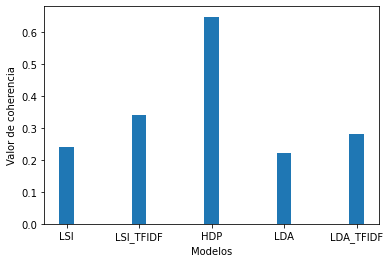

In [71]:
evaluate_bar_graph([lsi_coherence, lsi_tfidf_coherence, hdp_coherence, lda_coherence, lda_tfidf_coherence],
                   ['LSI', 'LSI_TFIDF' , 'HDP', 'LDA', 'LDA_TFIDF'])

<a id="analisis"></a>
## Analisis de Modelo

### Analsis de temas
Como Latent Dirichlet Allocation es el algoritmo mas ampliamente usado y es complatible con la libreria pylab seguirmos usandolo para optimizarlo y logran un mejor valor de coherencia 

In [72]:
def coherence_values_computation(modelo,dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = modelo(corpus=corpus, num_topics=num_topics, id2word=dictionary
      )
        model_list.append(model)
        coherencemodel = CoherenceModel( model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [73]:
model_list, coherence_values = coherence_values_computation (LdaModel,
   dictionary=dictionary, corpus=corpus, texts=texts, 
   start=1, limit=20, step=4)
limit=20; start=1; step=4;
x = range(start, limit, step)

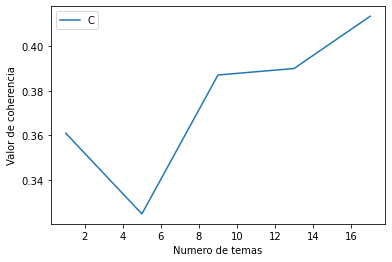

In [74]:
plt.plot(x, coherence_values)
plt.xlabel("Numero de temas")
plt.ylabel("Valor de coherencia")
plt.legend(("Coherencia"), loc='best')
plt.show()

### Tema que mas caracteriza a cada tweet
Mediante la función creada dominant_topics obtendremos los temas que mas caracterizan a cada tweet. Además, muestra la contribución de cada tema al tweet 

In [81]:
def dominant_topics(ldamodel=lda_model, corpus=corpus, texts=texts, tweets = df.tweet):
    sent_topics_df = pd.DataFrame(data=np.zeros((df.shape[0],5)), columns=['Dominant_Topic', 'Topic_Keywords','tema_0','tema_1','tema_2'])
    
    # recorro todo el corpus para obtener la contribucion de cada tema a tweet
    for i, row in enumerate(lda_model[corpus]):
        # Agrego como contribuye cada tema en el tweet
        for tema in row:
            sent_topics_df['tema_'+str(tema[0])][i] = tema[1]
        
        # ordeno por el tema que mas contribuye a cada tweet 
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # recorro las contribuciones de los tema al tweet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # me quedo solo con el tema que mas contribuye al tweet 
                
                # guardo como esta conpuesto el tema que mas influencia tienen en el tweet y cuanto contribuye cada palabra al tema
                wp = lda_model.show_topic(topic_num)
                
                # sepero cada palabra que compone al tema principal por una coma
                topic_keywords = ", ".join([word for word, prop in wp])
                
                # le agrego al data frame el tema que domina y las palabras claves de ese tema
                sent_topics_df['Dominant_Topic'][i] = int(topic_num)
                sent_topics_df['Topic_Keywords'][i] = topic_keywords
            else:
                break

    #le agrego al data frame el texto ya listo con el que entrene el modelo y con los tweet sin limpiar
    sent_topics_df["texto_listo"] = texts
#     sent_topics_df["tweets_original"] = tweets
    sent_topics_df = pd.merge(sent_topics_df,tweets.reset_index(drop=True),how="left",left_index=True,right_index=True)
    return(sent_topics_df)

Veo el modelo solo con el count vectorizer 

In [82]:
df_topic_sents_keywords = dominant_topics(ldamodel=lda_model, corpus=corpus, texts=texts)
df_topic_sents_keywords.sample(5)

,Dominant_Topic,Topic_Keywords,tema_0,tema_1,tema_2,texto_listo,tweet
3256,0.0,"caso, argentino, positivo, parir, confirmar, provincia, santo, vacuno, muerte, contagio",0.900166,0.049532,0.050302,"[persianasbajas, afirmar, local, shoppings, cerrarian, inactividad]",persianasbajas coronavirus afirman que hasta un 15 de los locales de los shoppings cerrarian por la inactividad
1794,1.0,"parir, argentino, comer, virus, coronar, salud, pandemia, gobernar, contagiar, caso",0.212883,0.604642,0.182475,[oriana],oriana con coronavirus yo solo haciendo la cuarentena
742,0.0,"caso, argentino, positivo, parir, confirmar, provincia, santo, vacuno, muerte, contagio",0.773518,0.113212,0.113270,"[che, turquia]",che en turquia no hay coronavirus
4180,1.0,"parir, argentino, comer, virus, coronar, salud, pandemia, gobernar, contagiar, caso",0.111972,0.776009,0.112019,"[mutacion, dipy]",es una mutacion del coronavirus ese dipy
3481,1.0,"parir, argentino, comer, virus, coronar, salud, pandemia, gobernar, contagiar, caso",0.086090,0.888944,0.024965,"[capacitar, parir_enfrentar, crisis, paises, liderar, mujer, contar, entrar, responder, crisis, seriar, nadar, aportar, sinnosotras]",estamos capacitadas para enfrentar esta crisis los paises liderados por mujeres se cuentan entre los que mejor respondieron a la crisis del coronavirus en serio no tenemos nada que aportar es sinnosotras


Ahora el modelo con la transformación tf idf 

In [83]:
df_topic_sents_keywords_tfidf = dominant_topics(ldamodel=lda_model_tfidf, corpus=corpus_tfidf, texts=texts)

In [84]:
df_topic_sents_keywords_tfidf.sample(5)

,Dominant_Topic,Topic_Keywords,tema_0,tema_1,tema_2,texto_listo,tweet
4475,0.0,"caso, argentino, positivo, parir, confirmar, provincia, santo, vacuno, muerte, contagio",0.522175,0.089822,0.388002,"[pobre, hombre, plata, basura, creer, argentino, ilegal, mediar, campar, bola]",pobre hombre toda su plata a la basura quien iba a creer que un dia en la argentina iba a ser ilegal trabajar esta en el medio del campo coronavirus las bolas
4278,1.0,"parir, argentino, comer, virus, coronar, salud, pandemia, gobernar, contagiar, caso",0.295001,0.568636,0.136364,"[contagio, trasmision, comunitario]",coronavirus seis de cada diez contagios en el pais ya son por trasmision comunitaria
2855,2.0,"parir, argentino, caso, morir, comer, muerte, virus, hablar, ano, pandemia",0.094296,0.307434,0.598269,"[barrera, autopista, alguien, querer, salir, balazo, drop, rate]",barreras en las autopistas y si alguien quiere salir balazo coronavirus drops rate to 0
2237,0.0,"caso, argentino, positivo, parir, confirmar, provincia, santo, vacuno, muerte, contagio",0.812061,0.093828,0.094110,"[onesofiamp, bts, retransmitira, gratis, internet, vario, concierto]",onesofiamp coronavirus bts retransmitira gratis y por internet varios conciertos
4862,2.0,"parir, argentino, caso, morir, comer, muerte, virus, hablar, ano, pandemia",0.398035,0.112137,0.489829,"[casar_positivo, villa, santo, nicolas]",coronavirus un nuevo caso positivo en villa san nicolas


## Tweet que caracteriza a cada tema
Se genera un data frame con los primero 3 tweet que mejor caracterizan a cada tema, asi se puede ver mejor como esta compuesto cada tema. Primero el modelo solo con count vectorizer y luego con la transformación tf idf.

In [85]:
sent_topics_sorteddf_mallet = pd.DataFrame()

#  Agrupamos por cada uno de los temas
grupos_temas = df_topic_sents_keywords.groupby('Dominant_Topic')

# Agrupo en cada tema por el porcentaje de contribución y nos quedamos con el que mayor porcentaje tiene para cada tema
for i, tema in grupos_temas:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, tema.sort_values(['tema_'+str(int(i))], ascending=False)[:1]], axis=0)
    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet

,Dominant_Topic,Topic_Keywords,tema_0,tema_1,tema_2,texto_listo,tweet
0,0.0,"caso, argentino, positivo, parir, confirmar, provincia, santo, vacuno, muerte, contagio",0.972085,0.013794,0.014121,"[air, new, zealand, suspender, vuelo, aire, medir, sumo, suspension, vuelo, implementar, iberio, air, europa, klm, air, france, british, norwegian, lufthansa, edelweiss, united, airlines, aeromexico, noto_completo]",air new zealand suspende vuelos a buenos aires por el coronavirus esta medida se suma a la suspension de vuelos implementadas por iberia air europa klm air france british norwegian lufthansa edelweiss united airlines y aeromexico nota completa
1,1.0,"parir, argentino, comer, virus, coronar, salud, pandemia, gobernar, contagiar, caso",0.012408,0.973207,0.014385,"[vida, turnar, turnar, parir, respirar, turnar, parir, cagar, turnar, parir, comprar, turnar, parir, beber, turnar, parir, vivir, turnar, turnar, turnar, sacar, turnar, tenes, turnar, hijo_puto, coronar_virus]",ahora la vida es un turno turno para respirar turno para cagar turno para comprar turno para beber turno para vivir turno turno con turno saca turno tenes turno hijo de una gran puta con corona virus
2,2.0,"parir, argentino, caso, morir, comer, muerte, virus, hablar, ano, pandemia",0.012876,0.013881,0.973243,"[capitular, cuba, recibir, barco, ingle, milisegundo, braemar, enfermo, barado, bahamas, capitular, cuba, envia, medicos, italia, pedir, gobernar, agobiar, enfermedad, capitular, chino, atacar, virus, medicamento, cubano, interferon, alfa]",capitulo 1 cuba recibe un barco ingles ms braemar con enfermos de coronavirus barado en bahamas capitulo 2 cuba envia medicos a italia a pedido de su gobierno agobiado por la enfermedad capitulo 3 china ataca el virus con un un medicamento cubano interferon alfa 2b


In [87]:
sent_topics_sorteddf_mallet_tfidf = pd.DataFrame()

#  Agrupamos por cada uno de los temas
grupos_temas_tfidf = df_topic_sents_keywords_tfidf.groupby('Dominant_Topic')

# Agrupo en cada tema por el porcentaje de contribución y nos quedamos con el que mayor porcentaje tiene para cada tema
for i, tema in grupos_temas_tfidf:
    sent_topics_sorteddf_mallet_tfidf = pd.concat([sent_topics_sorteddf_mallet_tfidf, tema.sort_values(['tema_'+str(int(i))], ascending=False)[:1]], axis=0)
    
sent_topics_sorteddf_mallet_tfidf.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet_tfidf

,Dominant_Topic,Topic_Keywords,tema_0,tema_1,tema_2,texto_listo,tweet
0,0.0,"caso, argentino, positivo, parir, confirmar, provincia, santo, vacuno, muerte, contagio",0.870779,0.067359,0.061862,"[nooo, mandemosle, chanta, gordo, sindicalista, biro, solucionar, 3o4, paro, salvaje, corto, avenir, bonn, berlin, mirar, aca, comer, ningun, problema, what, this, joderrr]",nooo mandemosle al chanta del gordo ese sindicalista biro y le soluciona todo con 3o4 paros salvajes y corta alguna avenida en bonn o en berlin digamos y ya esta mira aca como aa no tiene ningun problema coronavirus what is this joderrr
1,1.0,"parir, argentino, comer, virus, coronar, salud, pandemia, gobernar, contagiar, caso",0.066743,0.872835,0.060422,"[venir, lacasafuerte5, rcde, 25jun, velosinetiquetas, thetwilightzone, hong, puro, cantantefemenina, lavarparacuidar, liso, managershows, elegidostelefe, cuervotinelli, managementicon, losangelesok, charrymanager, devoto, village, car, wash, amp, store]",266 se viene lacasafuerte5 rcde covid19 25jun coronavirus velosinetiquetas thetwilightzone Hong puro cantantefemenina lavarparacuidar lisa managershows elegidostelefe cuervotinelli managementicon losangelesok charrymanager at devoto village car wash amp store
2,2.0,"parir, argentino, caso, morir, comer, muerte, virus, hablar, ano, pandemia",0.062955,0.063835,0.873210,"[licenciar, parir_prevenir, kicillofok, magariovero, nkreplak, licdanielarroyo, baprovincia, baeducacion, defensacivilba, trabajopba, agrariopba, minmujerespba, secdemediospba, saludbap, regsanxi, redesyregiones, hcdiputadosba, senadoba, deportesgba, agenciadelp]",licencias para prevenir el coronavirus kicillofok magariovero nkreplak licdanielarroyo baprovincia baeducacion defensacivilba trabajopba agrariopba minmujerespba secdemediospba saludbap regsanxi redesyregiones hcdiputadosba senadoba deportesgba agenciadelp


## Volumen y distribución de cada tema
Generamos un data frame para ve cuanta cantidad de tweet comprende cada tema y su respectivo porcentaje sobre el total. Primero el modelo solo con count vectorizer y luego con la transformación tf idf.

In [88]:
# Contamos cuantos tweet tiene cada tema 
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

#  Sacamos el porcentaje que representa cada tema sobre el total de tweet
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

#  Nos quedamos con las columnas de los temas que mas reprensentan a los tweet y con las palabras claves de cada tema
topic_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()

# Juntamos las tres variables
contribucion_temas = pd.merge(left=topic_keywords,right=topic_contribution,how="left",left_on="Dominant_Topic",right_index=True)
contribucion_temas = pd.merge(left=contribucion_temas,right=topic_counts,how="left",left_on="Dominant_Topic_x",right_index=True)
contribucion_temas.columns = ['Dominant-Topic', 'Topic-Keywords', 'Porcentaje_tweet', 'Cantidad_tweet']
contribucion_temas

,Dominant-Topic,Topic-Keywords,Porcentaje_tweet,Cantidad_tweet
0,2.0,"parir, argentino, caso, morir, comer, muerte, virus, hablar, ano, pandemia",0.3380,1988
1,1.0,"parir, argentino, comer, virus, coronar, salud, pandemia, gobernar, contagiar, caso",0.2772,1630
2,0.0,"caso, argentino, positivo, parir, confirmar, provincia, santo, vacuno, muerte, contagio",0.3848,2263


In [90]:
# Contamos cuantos tweet tiene cada tema 
topic_counts_tfidf = df_topic_sents_keywords_tfidf['Dominant_Topic'].value_counts()

#  Sacamos el porcentaje que representa cada tema sobre el total de tweet
topic_contribution_tfidf = round(topic_counts_tfidf/topic_counts_tfidf.sum(), 4)

#  Nos quedamos con las columnas de los temas que mas reprensentan a los tweet y con las palabras claves de cada tema
topic_keywords_tfidf = df_topic_sents_keywords_tfidf[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()

# Juntamos las tres variables
contribucion_temas_tfidf = pd.merge(left=topic_keywords_tfidf,right=topic_contribution_tfidf,how="left",left_on="Dominant_Topic",right_index=True)
contribucion_temas_tfidf = pd.merge(left=contribucion_temas_tfidf,right=topic_counts_tfidf,how="left",left_on="Dominant_Topic_x",right_index=True)
contribucion_temas_tfidf.columns = ['Dominant-Topic', 'Topic-Keywords', 'Porcentaje_tweet', 'Cantidad_tweet']
contribucion_temas_tfidf

,Dominant-Topic,Topic-Keywords,Porcentaje_tweet,Cantidad_tweet
0,2.0,"parir, argentino, caso, morir, comer, muerte, virus, hablar, ano, pandemia",0.3384,1990
1,1.0,"parir, argentino, comer, virus, coronar, salud, pandemia, gobernar, contagiar, caso",0.2867,1686
2,0.0,"caso, argentino, positivo, parir, confirmar, provincia, santo, vacuno, muerte, contagio",0.3749,2205


<a id="puesta"></a>
## Puesta en producción
Se crea una clase para la puesta en producción y poder determinar a que tema pertenece cada tweet nuevo ingresado

In [91]:
class Agrupacion(Preprocesamiento):
    
    # Limpio el texto, elimino las stopwords y genero una lista donde cada palabra es un item de la lista.
    def texto_separado(self, texto):
        # La función texto_listo es heredada de la clase padre
        texto_limpio = self.texto_listo(texto)
        
        # Genero los bigramas de las palbras
        bigramas = gensim.models.Phrases(texto_limpio)
        
        # Creo una lista con los bigramas incluidos
        texto_listo = [bigramas[line] for line in texto_limpio]
        
        # Devuelve el texto limpip 
        return texto_listo
    
    #Generamos el diccionario de las palabras
    def diccionario(self,texto):
        texto_listo = self.texto_separado(texto)
        return Dictionary(texto_listo)
    
    # Generamos la transformación tf_idf:
    def tf_idf(self,corpus,dicctionary):
        tfidf = TfidfModel(corpus = corpus,id2word=dictionary)
        corpus_tfidf = tfidf[corpus]
        return corpus_tfidf
    
    # Generamos el corpus de los textos pasados
    def corpus(self,texto):
        texto_listo = self.texto_separado(texto)
        dictionary = self.diccionario(texto)
        corpus = [dictionary.doc2bow(text) for text in texto_listo]
        return corpus
    
    # Con esta función voy a crear un data frame con los temas y la proporción que cada tweet tiene del mismo. Además, muestra el de mayor importancia
    def temas(self, texto,modelo,tipo="vector"):
        # Genero el corpus
        if tipo == "vector":
            corpus = self.corpus(texto)
        elif tipo == "tfidf":
            corpus_tfidf = self.corpus(texto)
            diccionario = self.diccionario(texto)
            corpus = self.tf_idf(corpus_tfidf,diccionario)
        else:
            return "tipo incorecto"
        # Genero la cantida de temas y las columnas del data frame
        temas = ["tema_"+str(i) for i in range(len(modelo.show_topics()))]
        columnas = ["tema_dominante"] + temas + ["texto_listo","tweet"]
        
        # Genero el data frame con un tamaño igual a la cantidad de filas en el texto y con n columnas igual al tamaño de la variable columnas
        df_temas = pd.DataFrame(np.zeros((texto.shape[0],len(columnas))),columns=columnas)
        
        # completo los campos del data frame
        df_temas["texto_listo"] = self.texto_separado(texto)
        df_temas["tweet"] = texto.reset_index(drop=True)
        
        # Se recorre cada texto para identificar la contribución de cada tema al texto
        for index,temas in enumerate(modelo[corpus]):
            for porcentaje in temas:
                #Agrego la contribución de cada tema
                df_temas["tema_"+str(porcentaje[0])][index] = porcentaje[1]
            
            # Por ultimo agrego al data frame en una columna aparte cual es el tema dominante en cada texto
            temas_ordenados = sorted(temas,key=lambda x: (x[1]), reverse=True)
            df_temas["tema_dominante"][index] = temas_ordenados[0][0]
        return df_temas

In [105]:
# Realizo unas pruebas
prueba_tweet = pd.Series(["Que cuarentena de mierda, no se acaba mas, basta ya","bien alberto alargando la cuarentena, hay que parar al virus","Hoy 100 muertes mas, y se suman 10 mil casos diarios","odio la cuerentan, vamos camino a una crisis, hay que abrir el pais","sigue subiendo los casos, ya van por 5 mil","hay que alargar la cuarentena hasta que no haya mas virus, mequedoencasa","yo me quedo en casa","messi se va del barsa","messi se va del barsa, diario informa","cuando acaba la cuanrentena, esto es una dictadura","todos juntos paramos al coronavirus, vamos argentina"])
prediccion = Agrupacion()
prueba = prediccion.temas(prueba,lda_model)

ValueError: Length of values does not match length of index

In [106]:
prueba

,tema_dominante,tema_0,tema_1,tema_2,texto_listo,tweet
0,0.0,0.811497,0.088460,0.100043,"[mierda, acabar, basto]","Que cuarentena de mierda, no se acaba mas, basta ya"
1,2.0,0.087626,0.070706,0.841668,"[alberto, alargar, parar, virus]","bien alberto alargando la cuarentena, hay que parar al virus"
2,1.0,0.069981,0.839916,0.090103,"[muerte, sumir, caso, diario]","Hoy 100 muertes mas, y se suman 10 mil casos diarios"
3,0.0,0.873019,0.059869,0.067113,"[odiar, cuerentan, caminar, crisis, abrir]","odio la cuerentan, vamos camino a una crisis, hay que abrir el pais"
4,2.0,0.223456,0.090390,0.686154,"[seguir, subir, caso]","sigue subiendo los casos, ya van por 5 mil"
5,2.0,0.088016,0.088709,0.823274,"[alargar, virus, mequedoencasa]","hay que alargar la cuarentena hasta que no haya mas virus, mequedoencasa"
6,2.0,0.127423,0.114935,0.757642,"[quedar, casar]",yo me quedo en casa
7,2.0,0.118205,0.139180,0.742614,"[messi, barsa]",messi se va del barsa
8,1.0,0.074759,0.851021,0.074220,"[messi, barsa, diario, informar]","messi se va del barsa, diario informa"
9,1.0,0.376568,0.532047,0.091385,"[acabar, cuanrentena, dictadura]","cuando acaba la cuanrentena, esto es una dictadura"


In [107]:
# Realizo unas pruebas con el modelo con las transformación tf idf
prueba_tfidf = prediccion.temas(prueba_tweet,lda_model_tfidf,tipo="tfidf")

In [108]:
prueba_tfidf

,tema_dominante,tema_0,tema_1,tema_2,texto_listo,tweet
0,0.0,0.730214,0.130538,0.139249,"[mierda, acabar, basto]","Que cuarentena de mierda, no se acaba mas, basta ya"
1,0.0,0.485953,0.119555,0.394492,"[alberto, alargar, parar, virus]","bien alberto alargando la cuarentena, hay que parar al virus"
2,1.0,0.116000,0.740041,0.143959,"[muerte, sumir, caso, diario]","Hoy 100 muertes mas, y se suman 10 mil casos diarios"
3,0.0,0.774790,0.109327,0.115883,"[odiar, cuerentan, caminar, crisis, abrir]","odio la cuerentan, vamos camino a una crisis, hay que abrir el pais"
4,2.0,0.168332,0.138799,0.692870,"[seguir, subir, caso]","sigue subiendo los casos, ya van por 5 mil"
5,2.0,0.145332,0.133201,0.721467,"[alargar, virus, mequedoencasa]","hay que alargar la cuarentena hasta que no haya mas virus, mequedoencasa"
6,2.0,0.153431,0.182419,0.664150,"[quedar, casar]",yo me quedo en casa
7,2.0,0.161415,0.168718,0.669868,"[messi, barsa]",messi se va del barsa
8,1.0,0.326240,0.543669,0.130091,"[messi, barsa, diario, informar]","messi se va del barsa, diario informa"
9,0.0,0.514976,0.343769,0.141255,"[acabar, cuanrentena, dictadura]","cuando acaba la cuanrentena, esto es una dictadura"
